# Atom Grids

[AtomGrid](../pyapi/grid.atomgrid.rst#grid.atomgrid.AtomGrid) objects have several capabilities useful for quantum chemistry applications. In the following these will be explored as practical examples. For these examples we will use the He atom as a test case. The format checkpoint file wavefunction is included in "doc/notebooks/He.fchk" and is
read using the [IOData](https://github.com/theochem/iodata) package.

In [8]:
import numpy as np
from iodata import load_one

mol = load_one("He_t.fchk")

print(f"Coordinates of the atoms \n {mol.atcoords}")
print(f"Atomic numbers of the atom \n {mol.atnums}")

Coordinates of the atoms 
 [[0. 0. 0.]]
Atomic numbers of the atom 
 [2]


First we define a radial grid. In this case we use a linear grid with 100 points equally spaced between 0.1 and 10.0 bohr.

In [9]:
from grid import AtomGrid
from grid import GaussLegendre, BeckeRTransform
import numpy as np

# Construct a radial grid
rad_point_num = 150
oned_grid = GaussLegendre(npoints=rad_point_num)
radial_grid = BeckeRTransform(0.0, R=1.5).transform_1d_grid(oned_grid)  #BeckeRTransform(0.0, R=2.0).transform_1d_grid(oned_grid)

The atomic grid is determined by the (previous) radial grid and an angular grid. In this case we use a Lebedev-Laikov grid with a degree of 29. 

In [10]:
angular_degrees = [22]
atomgrid = AtomGrid(radial_grid, degrees=angular_degrees)
print(f"\n- Specified AtomGrid with {radial_grid.size} radial points and an angular grid with "
      f"{angular_degrees} degrees (Levedev-Laikov) has {atomgrid.size} points.")



- Specified AtomGrid with 150 radial points and an angular grid with [22] degrees (Levedev-Laikov) has 29100 points.


### Example: Electron Density

The electron density $\rho(\mathbf{r})$ on the grid points can be computed using the [gbasis](https://github.com/theochem/gbasis) package. These values will be used to showcase the capabilities of the [AtomGrid](../pyapi/grid.atomgrid.rst#grid.atomgrid.AtomGrid) class.

In [11]:
from gbasis.wrappers import from_iodata
from gbasis.evals.density import evaluate_density

# Construct molecular basis from wave-function information read by IOData
basis, type = from_iodata(mol)

# Compute the electron density
rdm = mol.one_rdms["scf"]
electron_density = evaluate_density(rdm, basis, atomgrid.points, coord_type=type)
print(f"Shape of the electron density: {electron_density.shape}.")

# Integrate using the molecular grid
print(f"The integration of the electron density {atomgrid.integrate(electron_density)} "
      "should be close to the number of electrons.")
print(f"Number of electrons: {mol.atnums[0]}.")

Shape of the electron density: (29100,).
The integration of the electron density 1.9999999911143622 should be close to the number of electrons.
Number of electrons: 2.


#### 1. Calculate the radial electron density distribution

The radial distribution of the electron density is the projection of the electron density in the radial coordinate. It describes the probability of finding an electron of the system in the spherical shell between $r$ and $r + dr$. 

This is calculated by integrating the electron density over the angular coordinates. Please note the factor $r^{2} sin(\phi)$ in the integral. This is due to the fact that the electron density is defined in spherical coordinates and the volume element is given by $dV = r^{2} sin(\phi) dr d\theta d\phi$.

$$\rho(r) = \int \int \rho(r, \theta, \phi) r^{2} sin(\phi) d\theta d\phi$$

this can be rewritten for the radial grid points as:

$$\rho(r_i) = r_{i}^{2}  \int  \int  \rho(r, \theta, \phi)sin(\phi) d\theta d\phi$$

where $r_i$ is a radial grid point. 

In the following example we calculate the radial electron density distribution for the He atom in the triplet ($1s^2 2s^1$) state using the previously defined atomic grid and the electron density values calculated on the grid points.


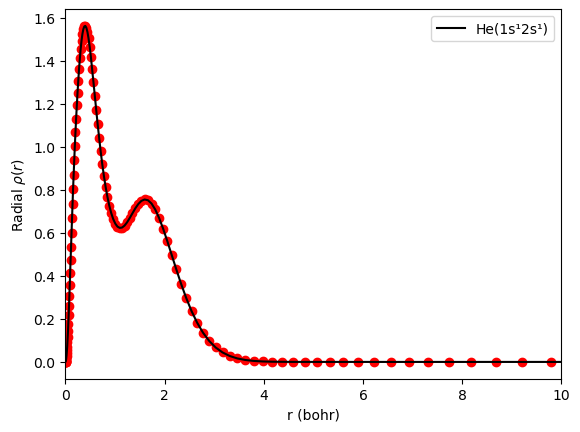

In [12]:
import matplotlib.pyplot as plt

# find the radial electron density distribution using atomgrid angular
# integration
radial_rho =  atomgrid.integrate_angular_coordinates(electron_density)
radial_rho *= radial_grid.points**2

# plot the radial electron density
y_axis = radial_rho
x_axis = radial_grid.points

plt.plot(x_axis, y_axis, label='He(1s¹2s¹)', color='black')
plt.scatter(x_axis, y_axis, color='red', marker='o')
plt.xlabel("r (bohr)")
plt.ylabel(r"Radial $\rho(r)$")
# Set the x-axis range
plt.xlim(0, 10)

plt.legend()
plt.show()


The maximum values of the radial electron density distribution corresponds to the radial position with maximum probability of finding an electron. In this case there are two maximum values corresponding to the two electrons. The first one (left to right) corresponds to the $1s$ orbital and the second one to the $2s$ orbital.

The radial electron density distribution integrates to the total number of electrons in the system over the radial grid. In this case we have two electrons and the integral should be close to 2.0.



In [13]:
print(f"The integration of the electron density: {radial_grid.integrate(radial_rho)} is close to "
      f"the number of electrons: {mol.atnums[0]}.")

The integration of the electron density: 1.9999999911143642 is close to the number of electrons: 2.


#### 2. Calculate classic coulomb repulsion energy

The classic coulomb repulsion energy $\mathbf{J}$ is defined as:

$$\mathbf{J} = \frac{1}{2} \int \int \frac{\rho(\mathbf{r}) \rho(\mathbf{r}')}{|\mathbf{r} - \mathbf{r}'|} d\mathbf{r} d\mathbf{r}'$$

where $\rho(\mathbf{r})$ is the electron density and $\mathbf{r}$ is the position vector. This can be rewritten for the grid points as:

$$E_{rep} = \frac{1}{2} \sum_{i} \sum_{j} \frac{\rho(\mathbf{r}_i) w_i \rho(\mathbf{r}_j) w_j }{|\mathbf{r}_i - \mathbf{r}_j|}$$

where $\mathbf{r}_i$ and $\mathbf{r}_j$ are grid points and $w_i$ and $w_j$ are the corresponding weights.

The issue arises when $i = j$, resulting in a zero denominator and an undefined energy. To address this, distinct grids for $\mathbf{r}_i$ and $\mathbf{r}_j$ should be employed within the same spatial domain, ensuring that grid points do not coincide. This can be achieved by introducing a second atomic grid with different angular degree. The electron density values on this second grid can be obtained by interpolating from the values on the first grid, utilizing the interpolation method provided by the [AtomGrid](../pyapi/grid.atomgrid.rst#grid.atomgrid.AtomGrid) class.



In [14]:
# Construct a radial grid for the auxiliary atomgrid
aux_rad_point_num = rad_point_num - 1
oned_grid = GaussLegendre(npoints=aux_rad_point_num)
radial_grid = BeckeRTransform(0.0, R=1.5).transform_1d_grid(oned_grid) 

# Construct the auxiliary atomgrid
angular_degrees = [23]
aux_atomgrid = AtomGrid(radial_grid, degrees=angular_degrees)

# interpolate the electron density on the auxiliary atomgrid points
interpolate_electron_density = atomgrid.interpolate(electron_density)
electron_density_aux = interpolate_electron_density(aux_atomgrid.points)

classic_coulomb = 0.
# for each point in the atomgrid
for i in range(atomgrid.size):
    # compute its distance to all the points in the auxiliary atomgrid
    distances = np.linalg.norm(atomgrid.points[i] - aux_atomgrid.points, axis=1)
    # compute the coulomb repulsion between the electron density at the atomgrid point and the 
    # auxiliary atomgrid points
    coulomb_points =  atomgrid.weights[i] * electron_density[i] * electron_density_aux / distances / 2
    # integrate the coulomb repulsion between the electron density at the atomgrid point and the
    # auxiliary atomgrid points
    classic_coulomb += aux_atomgrid.integrate(coulomb_points)

print(f"The classic Coulomb energy is: {classic_coulomb} hartree.")


The classic Coulomb energy is: 1.772374684606753 hartree.
